# **Lab 3: Mitigating Bias Using Fairlearn**

Previously we explored bias metrics and measuring bias in a binary classification machine learning model. In this Lab we will continue working on the same data and ML model, this time using Fairlearn to perform bias-mitigating interventions in three different ways:

*   **Preprocessing interventions:** These algorithms transform the dataset (prior to training a model) in order to mitigate possible unfairness present in the data. 
    - Example: One way to think about bias is as correlation between sensitive and non-sensitive features in the dataset. By applying the [CorrelationRemover](https://fairlearn.org/v0.7.0/api_reference/fairlearn.preprocessing.html#fairlearn.preprocessing.CorrelationRemover), these correlations are projected away while details from the original data are retained as much as possible (as measured by least-squares error). The user can control the level of projection via the `alpha` parameter. 

*   **Reduction algorithms:** At a high level, the reduction algorithms within Fairlearn enable bias mitigation for machine learning models using user-provided constraints. The two available algorithms are [Exponentiated Gradient](https://fairlearn.org/v0.7.0/api_reference/fairlearn.reductions.html#fairlearn.reductions.ExponentiatedGradient) and [Grid Search](https://fairlearn.org/v0.7.0/api_reference/fairlearn.reductions.html#fairlearn.reductions.GridSearch). The reductions approach seeks to reduce binary classification and regression problems subject to fairness contrains to a sequence of weighted classification problems. As a result, the reduction algorithms in Fairlearn only require a wrapper to access to any “base” learning algorithm. By this we mean that the “base” algorithm only needs to implement `fit` and `predict` methods (like any standard scikit-learn estimator) but it does not need to have any knowledge of the desired fairness constraints or sensitive features.

    From an API perspective this looks as follows in all situations:

  > reduction = Reduction(base_estimator, constraints, **kwargs)  
  > reduction.fit(X_train, y_train, sensitive_features=sensitive_features)  
  > reduction.predict(X_test)  

*   **Postprocessing algorithms:** The postprocessing algorithms transform the *outputs* of a classification or regression model to mitigate bias. For example, the [ThresholdOptimizer](https://fairlearn.org/v0.7.0/api_reference/fairlearn.postprocessing.html#fairlearn.postprocessing.ThresholdOptimizer) takes as input an existing classifier and the sensitive feature, and derives a monotone transformation of the classifier’s prediction to enforce the specified parity constraints.

This Lab is divided into the following parts:

1. Load the data as we did in Lab 2
2. Use preprocessing algorithms to mitigate bias
3. Use reduction algorithms to mitigate bias
4. Use postprocessing algorithms to mitigate bias
5. Compare all of our efforts

#1. Load the data  (This code is all from Lab 2)

If you have any doubts about Part 1, please refer to Lab 2, in which we did the same steps.

In [1]:
# %%capture
#@markdown
!pip install fairlearn
!pip install folktables
!git clone https://github.com/lurosenb/superquail

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'superquail'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 1), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), 11.88 KiB | 141.00 KiB/s, done.


In [2]:
#@markdown Import statments
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm

from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output

In [26]:
#@markdown Import data 
data, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)

print(data.shape)
data.head()

(70000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,66.0,6.0,16.0,1.0,6410.0,6.0,0.0,20.0,1.0,8.0,0.0
1,56.0,1.0,24.0,1.0,3100.0,36.0,0.0,30.0,1.0,6.0,1.0
2,65.0,1.0,21.0,1.0,1900.0,6.0,0.0,42.0,1.0,1.0,1.0
3,56.0,1.0,19.0,5.0,440.0,6.0,0.0,40.0,2.0,1.0,1.0
4,34.0,1.0,20.0,1.0,3500.0,6.0,0.0,40.0,2.0,1.0,0.0


In [27]:
#@markdown Drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  float64
 2   SCHL    70000 non-null  float64
 3   MAR     70000 non-null  float64
 4   OCCP    70000 non-null  float64
 5   POBP    70000 non-null  float64
 6   RELP    70000 non-null  float64
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  float64
 9   RAC1P   70000 non-null  float64
 10  PINCP   70000 non-null  float64
dtypes: float64(11)
memory usage: 6.4 MB


In [28]:
#@markdown Change data types of categorical features
numerical_cols = ['AGEP','WKHP']
categorical_cols = ['COW','SCHL','MAR','OCCP','POBP','RELP','RAC1P','SEX']

for col in categorical_cols:
  data[col] = data[col].astype('int')
  data[col] = data[col].astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  object 
 2   SCHL    70000 non-null  object 
 3   MAR     70000 non-null  object 
 4   OCCP    70000 non-null  object 
 5   POBP    70000 non-null  object 
 6   RELP    70000 non-null  object 
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  object 
 9   RAC1P   70000 non-null  object 
 10  PINCP   70000 non-null  float64
dtypes: float64(3), object(8)
memory usage: 6.4+ MB


In [29]:
#@markdown Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,1.566104,6,16,1,6410,6,0,-1.374391,1,8,0.0
1,0.892955,1,24,1,3100,36,0,-0.607203,1,6,1.0
2,1.498789,1,21,1,1900,6,0,0.313423,1,1,1.0
3,0.892955,1,19,5,440,6,0,0.159985,2,1,1.0
4,-0.587974,1,20,1,3500,6,0,0.159985,2,1,0.0


In [30]:
#@markdown One-hot encode categorical features
data = pd.get_dummies(data)

#since the sex attribute is already binary we can drop one of the redundant dummy columns
#note: males are now labeled as 1 and females are labeled as 0
data.drop(columns=['SEX_2'], inplace=True)
data.rename(columns={'SEX_1':'SEX'}, inplace=True)

data.head()

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,SEX,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
0,1.566104,-1.374391,0.0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0.892955,-0.607203,1.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1.498789,0.313423,1.0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0.892955,0.159985,1.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,-0.587974,0.159985,0.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [31]:
#@markdown Split data into training and test sets
target = data['PINCP']
data.drop(columns='PINCP', inplace=True)

#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (56000, 809)
y_train shape: (56000,)
X_test shape: (14000, 809)
y_test shape: (14000,)


Next, we will replicate our procedure from Lab 2 where we train a classifier and evaluate its accuracy and bias.

In [32]:
#@markdown Implement logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf_accuracy = clf.score(X_test, y_test)

clear_output()

print(f'Logistic Regression test accuracy: {clf_accuracy:.4f}')

Logistic Regression test accuracy: 0.8189


In [33]:
#@markdown Evaluate the fairness of the classifier using demographic_parity_difference and demographic_parity_ratio
#note: we are conducting this analysis over the test set

#compute test predictions
y_pred = clf.predict(X_test)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Demographic parity difference: 0.1483
Demographic parity ratio: 0.6849
Male selection rate: 0.4707
Female selection rate: 0.3224


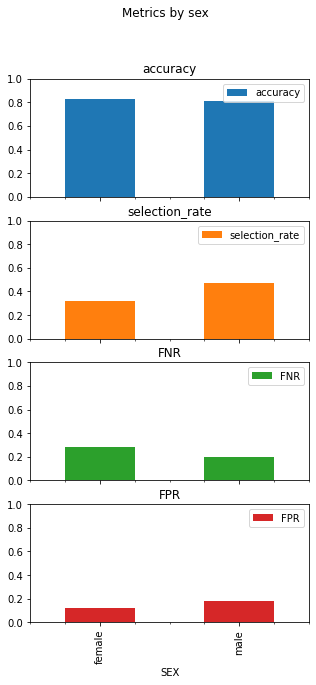

In [34]:
#@markdown Evaluate (plot) the fairness of the classifier using the MetricFrame class

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_sex.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

As before, we see that there are some disparities in the selection rate, FPR, and FNR between males and females. Namely, men have a higher selection rate because the have both a lower false negative rate and higher false positive rate.

#2. Preprocessing algorithms

Here, we will use the Correlation Remover Preprocessing algorithm to attempt to mitigate bias in our model.  The Correlation Remover will modify the original data, and then we will use this modified data in place of our original data to train our predictive model.

- For example, suppose that `WKHP`, the number of hours worked per week, was well correlated with sex. Then, consider a model trained on that data which uses `WKHP` to predict someone's income. Thanks to that correlation, that model is also using `SEX` to predict income.

To resolve this, this "Correlation Remover" takes our features that we are allowed to predict from, and forcibly changes their values a little bit so that the resulting features are _uncorrelated_ with sex. Then, a blind model like we used last week shouldn't have a way to distinguish men and women.

- Notably, the "Correlation Remover" is a statistical model, and it needs to be trained on data. So, we fit the Remover on training data, and apply that model to de-correlate both the training and test data.

- This removes _linear correlations_ in the data. If there's a nonlinear correlations in the data, and if the classifier model is able to learn nonlinear correlations, then it's not obvious that "Correlation Remover" will fix bias.

Before implementing the correlation remover, let us take a look again at the correlations between the numeric features and the target variable.

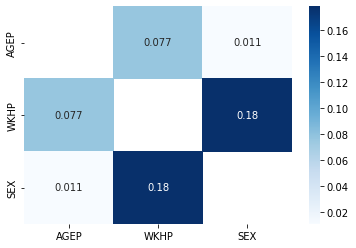

In [35]:
#@title
# Plot pairwise correlations between numeric features
numerical_cols = ['AGEP','WKHP','SEX'] # We'll just pretend sex is numeric for this figure
sn.heatmap(X_train[numerical_cols].corr(), mask=np.identity(len(X_train[numerical_cols].corr())), annot=True, cmap='Blues')
plt.show()

The correlation between `sex` and `hours worked per week` is non-negligable. Note that we only plotted correlations between `sex` and the numerical features, event though we will also remove correlations between `sex` and the one-hot encoded categorical features.

In [36]:
#@title
# Implement Correlation Remover
column_names = list(data.columns.values)
column_names.remove("SEX")

cr = CorrelationRemover(sensitive_feature_ids=['SEX'], alpha=1.0)

# Fit our correlation removing model on *only* training data
cr.fit(X_train)

# Remove correlations on both training and test data

X_train_cr = cr.transform(X_train) # returns a numpy array, not a dataframe
X_train_cr = pd.DataFrame(X_train_cr, columns=column_names, index=X_train.index)
X_train_cr['SEX'] = X_train['SEX']

X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr, columns=column_names, index=X_test.index)
X_test_cr['SEX'] = X_test['SEX']

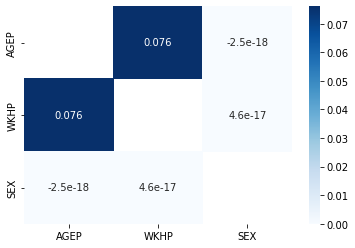

In [37]:
#@title
# We can plot the pairwise correlation again to see if correlation with `SEX` has decreased

sn.heatmap(X_train_cr[numerical_cols].corr(), mask=np.identity(len(X_train_cr[numerical_cols].corr())), annot=True, cmap='Blues')
plt.show()

Notice that the moderate-to-small correlations with `sex` are now virtually zero.

In principle, we have done this also to all our categorical data too, though this preprocessing algorithm treated that data like it was numerical, and those columns are no longer only full of 0s and 1s.


In [38]:
#@title
X_train_cr.head()

,AGEP,WKHP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,...,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX
31604,1.914337,-2.644417,0.028689,-0.024573,-0.022959,-0.008807,0.007996,1.009084,0.010887,-0.000316,...,1.009429,-0.002747,-0.000182,-0.000002,-0.000185,-0.010283,-0.000141,0.006205,-0.002093,0
10793,0.568039,0.347615,1.028689,-0.024573,-0.022959,-0.008807,0.007996,0.009084,0.010887,-0.000316,...,0.009429,-0.002747,-0.000182,-0.000002,-0.000185,0.989717,-0.000141,0.006205,-0.002093,0
52093,-1.451409,0.347615,0.028689,0.975427,-0.022959,-0.008807,0.007996,0.009084,0.010887,-0.000316,...,0.009429,-0.002747,0.999818,-0.000002,-0.000185,-0.010283,-0.000141,0.006205,-0.002093,0
25134,-1.069634,-0.008287,0.974271,0.022038,0.020591,0.007898,-0.007171,-0.008146,-0.009764,0.000283,...,-0.008456,0.002464,0.000163,0.000002,0.000166,0.009222,0.000126,0.994435,0.001877,1
31569,1.039243,1.881991,1.028689,-0.024573,-0.022959,-0.008807,0.007996,0.009084,0.010887,-0.000316,...,1.009429,-0.002747,-0.000182,-0.000002,-0.000185,-0.010283,-0.000141,0.006205,-0.002093,0


Next, using the de-correlated data, we again implement our Logistic Regression classifier.

In [39]:
#@title
#implement logistic regression

# First, drop sex from the data, which is now (hopefully) meaningful since it's uncorrelated with other variables now
X_train_cr.drop(['SEX'], axis=1, inplace=True)
X_test_cr.drop(['SEX'], axis=1, inplace=True)

# Train the Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train_cr, y_train)
clf_accuracy_cr = clf.score(X_test_cr, y_test)

clear_output()

print(f'Logistic Regression with Correlation Remover test accuracy: {clf_accuracy_cr:.4f}')

Logistic Regression with Correlation Remover test accuracy: 0.8140


#**TODO 1**: Write code to evaluate the fairness metrics of the model implemented with the Correlation Remover. Specifically, show the demographic parity difference, demographic parity ratio, male selection rate, and female selection rate.

In [40]:
#@markdown 

# print the fairness of the unaltered model
print("Naive Model's results:")
print(f'  Demographic parity difference: {demo_parity_diff:.4f}')
print(f'  Demographic parity ratio: {demo_parity_ratio:.4f}')
print(f'  Male selection rate: {male_selection_rate:.4f}')
print(f'  Female selection rate: {female_selection_rate:.4f}')
print()


# evaluate fairness of the classifier with Correlation Remover
print('Correlation Remover results:')

# store a vector with the sex of everyone in the test data
X_test_sexes = X_test['SEX']

# compute test predictions
y_pred_cr = clf.predict(X_test_cr)

# compute demographic parity difference and demographic parity ratio
demo_parity_diff_cr = demographic_parity_difference(y_test, y_pred_cr, sensitive_features=X_test_sexes)
demo_parity_ratio_cr = demographic_parity_ratio(y_test, y_pred_cr, sensitive_features=X_test_sexes)
print(f'  Demographic parity difference: {demo_parity_diff_cr:.4f}')
print(f'  Demographic parity ratio: {demo_parity_ratio_cr:.4f}')

# compute selection rate for males and females
male_selection_rate_cr = selection_rate(y_test[X_test_sexes==1], y_pred_cr[X_test_sexes==1])
female_selection_rate_cr = selection_rate(y_test[X_test_sexes==0], y_pred_cr[X_test_sexes==0])
print(f'  Male selection rate: {male_selection_rate_cr:.4f}')
print(f'  Female selection rate: {female_selection_rate_cr:.4f}')


Naive Model's results:
  Demographic parity difference: 0.1483
  Demographic parity ratio: 0.6849
  Male selection rate: 0.4707
  Female selection rate: 0.3224

Correlation Remover results:
  Demographic parity difference: 0.0341
  Demographic parity ratio: 0.9180
  Male selection rate: 0.4159
  Female selection rate: 0.3818


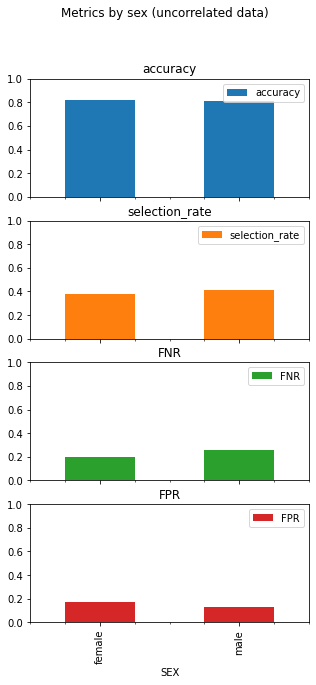

In [42]:
# @markdown #**TODO 2**: write some code in this cell that plots metrics using the `MetricFrame` class

# Write Code

#CHANGE IT

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test_sexes.replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_cr,
                             sensitive_features=sensitive_feature)

grouped_on_sex.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by sex (uncorrelated data)",
    )
plt.show()

#**TODO 3**: What are the main differences in terms of bias in the Logistic Regression model implemented before and after the Correlation Remover Pre-Processing algorithm? What do these results indicate in terms of the attributes' correlation with the feature "sex"?

**Answer:** The main differences is that in terms of bias, the model that accounts for the correlations with the sensitive variable performs better in terms of reducing specific group bias than the naive model. Thus, we find that these variables correlated with the senstitive variable of sex, were linearly correlated in a problematic sense. Correcting these made our model in other words, fairer.


#**TODO 4**: What would we expect the results to be if we use an alpha parameter less than 1.0 (standard)? What would happen if we use alpha equal to 0?

**Answer:** As explained in class, alpha is the parementer to control the amount of correlation removed in the dataset we are applying it to. If alpha is 1, we are basically removing all the bias possible in the data, whereas is alpha is lower than one, we are letting some slack for bias to remain present (but in small quantities). To make this clearer, a alpha equal to 0 will delete no bias from the data, meaning that it will remain unchanged.

#3. Reduction algorithms

Both **GridSearch** and **ExponentialGradient** can be used for binary classification and regression models, supporting the following fairness definitions:

*   **Demographic Parity:** ensures that the selection rate or percentage of samples with label = 1 is equal across all groups. Implicitly this means the percentage with label = 0 is equal as well.

*   **True Positive Rate Parity and False Positive Rate Parity:** ensures that the True Positive Rate (TP / TP + FN) **OR** the False Positive Rate (FP / FP + TN) is equal across all groups. In first case, we only consider samples with $Y = 1$ and ignore the samples with $Y = 0$, and in the second case vice versa.

*   **Equalized Odds:** ensures that both True Positive Rate (TP / TP + FN) **AND** the False Positive Rate (FP / FP + TN) are equal across all groups. The constraints represent the union of constraints for true positive rate and false positive rate. Thus, samples with both $Y = 1$ and $Y = 0$ are considered.

*   **Error Rate Parity:** ensures that the error rates should be the same across all groups. The __utility__ of our classifier on a single sample $X$ is 0 if we predicted the label correctly, and the utility is 1 otherwise. So, a large __total utility__ (i.e. sum of utilities across all test samples) here corresponds to a poor model.

*   **Control Features:** The above metrics (Demographic Parity, True and False Positive Rate Parity, Equalized Odds, and Error Rate Parity) happen to all fit a math definition which lets us call them __Moments__$\text{}^{\dagger}$. These moments all support __Control Features__ when applying their fairness constraints.
  1. Suppose we are designing a classifier to predict if someone will repay a loan. We may want to be fair towards sex. But, we also don't want to lose information about their annual income, so we want to control for their annual income somehow.
  2. We can split all people into groups based on their income level, and require fairness towards sex _within_ each group. We will not require fairness towards sex _between_ different groups.
  3. In this example, income level is a control feature.
  4. Formally, a control feature stratifies the dataset, and applies the fairness constraint within each stratum, but not between strata.
  5. This should be done with caution, since the control features might be correlated with the sensitive features due to historical biases.
  6. In the loan scenario, we might choose to control for income level, on the grounds that higher income individuals are more likely to be able to repay a loan. However, due to historical bias, there is a correlation between the income level of individuals and their race and gender.

$\phantom{}^{[\dagger]}$ _If you're curious, see https://arxiv.org/pdf/1803.02453.pdf for details on why these are called "moments"._

##3.1 GridSearch

Here, we implement the Grid Search intervention on our classifier and examine its effects on bias in our model.  `GridSearch` implements a simplified version of the [exponentiated gradient reduction](https://fairlearn.org/main/api_reference/generated/fairlearn.reductions.ExponentiatedGradient.html) intervention.  It generates a sequence of relabellings and reweightings and trains a predictor for each.  From there, users can select the model that generates the most favorable tradoff between accuracy and fairness for their specific purpose.

**NOTE**: this code will temporarily create several outputs which say `lbfgs failed to converge`. Ingore these messages.

In [ ]:
#@title
#first we specificy Demographic Parity as our fairness metric and generate a train a series of predictors
sweep = GridSearch(LogisticRegression(max_iter=100), constraints=DemographicParity())

sweep.fit(X_train, y_train, sensitive_features=X_train['SEX']) # This will take about 2 minutes

#GridSearch created a bunch of different predictors, stored in this list
predictors = sweep.predictors_

#next, we remove predictors which are dominated in the error-disparity space by others from the sweep
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    # Load the training and test data into ErrorRate and DemographicParity objects
    error = ErrorRate()
    error.load_data(X_train, y_train, sensitive_features=X_train['SEX'])
    disparity = DemographicParity()
    disparity.load_data(X_train, y_train, sensitive_features=X_train['SEX'])

    # error.gamma(classifier) and disparity.gamma(classifier) returns the actual error rate and statistical disparity
    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())


# A Dataframe of all predictors, their errors, and their disparities
all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

best_predictors = []

# for each predictor
for row in all_results.itertuples(): 
    # find the subset of all predictors with disparity <= this predictor's disparity
    # keep only the errors from that subset
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        # If this predictor has better error than all rows better disparity, add it to the list
        best_predictors.append(row.predictor)

clear_output()

In [ ]:
#@title
# here we calculate the accuracy and fairness metrics for our dominant models
# define a bunch of lists that will become Pandas dataframe columns
model_num = []
accuracy_gs = []
demo_parity_diff_gs = []
demo_parity_ratio_gs = []
male_selection_rate_gs = []
female_selection_rate_gs = []

# populate the lists
for i in range(len(best_predictors)):
    y_pred = best_predictors[i].predict(X_test)

    model_num.append("dominant_model_{0}".format(i))
    accuracy_gs.append(accuracy_score(y_test,y_pred))
    demo_parity_diff_gs.append(demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX']))
    demo_parity_ratio_gs.append(demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX']))
    male_selection_rate_gs.append(selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1]))
    female_selection_rate_gs.append(selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0]))

# make the lists into a single pandas dataframe
grid_search_results_df = pd.DataFrame()
grid_search_results_df['model'] = model_num
grid_search_results_df['accuracy'] = accuracy_gs
grid_search_results_df['demo_parity_diff'] = demo_parity_diff_gs
grid_search_results_df['demo_parity_ratio'] = demo_parity_ratio_gs
grid_search_results_df['male_selection_rate'] = male_selection_rate_gs
grid_search_results_df['female_selection_rate'] = female_selection_rate_gs

grid_search_results_df

,model,accuracy,demo_parity_diff,demo_parity_ratio,male_selection_rate,female_selection_rate
0,dominant_model_0,0.814357,0.125759,0.732061,0.469357,0.343598
1,dominant_model_1,0.788143,0.106964,0.771145,0.360421,0.467385


#**TODO 5**: If we decide to prioritize fairness over accuracy in our model, which of these dominant models would you select and why? Recreate the MetricFrame plots used previously for the selected model.

**Note: Results may changes with different runs.**


**Answer:** First, lets start from the fact that in terms of accuracy and fairness, this model implementation is not that good, so we will not prefer these models. Now, if we prioritize fairness over accuracy in these two models, we will go for the second model (dominant_model_1) which has a lower accuracy than the first one, but the Demographic parity difference is lower. Again, these two models perform pretty bad in comparison to different methods. But in the case we will pick one or the other, the second model will be our go to (higher demographic parity ratio as well)

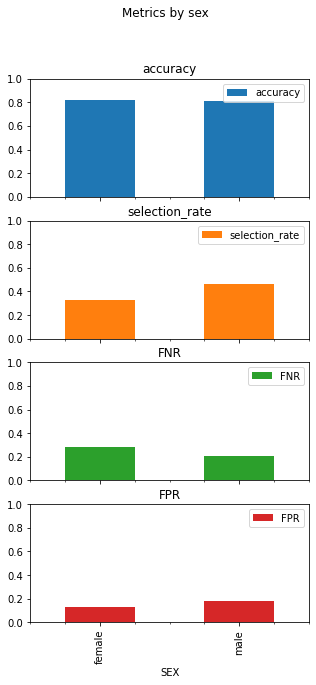

In [ ]:
#@markdown Plot the fairness metrics of the selected classifier using the MetricFrame class
selected_model_num = 0
y_pred_gs = best_predictors[selected_model_num].predict(X_test)

grouped_on_sex_grid_search = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_gs,
                             sensitive_features=sensitive_feature)
#plot the metric values
grouped_on_sex_grid_search.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

#**TODO 6**: What does a comparison of these two dominant models tell us about the relationship between accuracy and fairness in our models?

**Answer here:** It tells us that the relationship between accuracy and fairness is negatively correlated: higher accuracy leds to lower fairness, and viceversa. However, it is worth noting that this only happens in the algorithmic manipulation part. This might be because it overweights in certain areas, and the fairness is just artificially increased or viceversa. But if there is something to note, is that this technique is not improving accuracy nor fairness at the rates we desire (not that different from the baseline ones). So it might not be a great fit with this data examples

# 4 Postprocessing algorithms

The logistic regression classifier does not just predict the class of a given input. It can also provide a "confidence" of how likely it thinks the class is postive, as a number between 0 and 1. Often, any confidence above 0.5 is labeled as positive, and any confidence below 0.5 is labeled as negative. In this case, we say that 0.5 is the __confidence threshold__.

To achieve fairness, we will now consider a __postprocessing algorithm__ called [ThresholdOptimizer](https://fairlearn.org/v0.7.0/api_reference/fairlearn.postprocessing.html#fairlearn.postprocessing.ThresholdOptimizer).
The ThresholdOptimizer will use our dataset and the confidence scores of our logistic regression model in order to transform the confidence scores to create a more fair model.

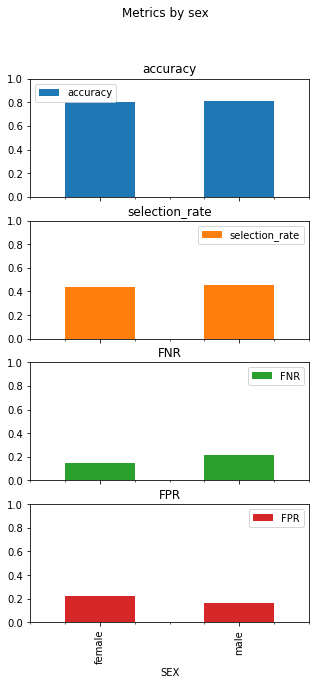

In [43]:
#@markdown

# Train a model on straightforward data
default_model = LogisticRegression(max_iter=500).fit(X_train, y_train)

# Make the post-processed model
postprocessed_model = ThresholdOptimizer(
    estimator=default_model,
    constraints='selection_rate_parity',
    objective='balanced_accuracy_score',
    prefit=True,
    predict_method='predict_proba'
)

# Fit the model to the training data
postprocessed_model.fit(X_train, y_train, sensitive_features=X_train['SEX'])

# Predict on the test data
y_pred_to = postprocessed_model.predict(X_test, sensitive_features=X_test['SEX'])  


# Make a metricframe
grouped_on_sex_to = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_to,
    sensitive_features=sensitive_feature
)

# Plot a metricframe grouped by sex
grouped_on_sex_to.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()


In [44]:
#@title
# print the fairness of the unaltered model
print("Naive Model's results:")
print(f'  Demographic parity difference: {demo_parity_diff:.4f}')
print(f'  Demographic parity ratio: {demo_parity_ratio:.4f}')
print(f'  Male selection rate: {male_selection_rate:.4f}')
print(f'  Female selection rate: {female_selection_rate:.4f}')
print()


# evaluate fairness of the classifier with Correlation Remover
print('ThresholdOptimizer results:')

#compute demographic parity difference and demographic parity ratio
demo_parity_diff_to = demographic_parity_difference(y_test, y_pred_to, sensitive_features=X_test_sexes)
demo_parity_ratio_to = demographic_parity_ratio(y_test, y_pred_to, sensitive_features=X_test_sexes)

print(f'  Demographic parity difference: {demo_parity_diff_to:.4f}')
print(f'  Demographic parity ratio: {demo_parity_ratio_to:.4f}')

#compute selection rate for males and females
male_selection_rate_to = selection_rate(y_test[X_test_sexes==1], y_pred_to[X_test_sexes==1])
female_selection_rate_to = selection_rate(y_test[X_test_sexes==0], y_pred_to[X_test_sexes==0])

print(f'  Male selection rate: {male_selection_rate_cr:.4f}')
print(f'  Female selection rate: {female_selection_rate_cr:.4f}')

Naive Model's results:
  Demographic parity difference: 0.1483
  Demographic parity ratio: 0.6849
  Male selection rate: 0.4707
  Female selection rate: 0.3224

ThresholdOptimizer results:
  Demographic parity difference: 0.0205
  Demographic parity ratio: 0.9548
  Male selection rate: 0.4159
  Female selection rate: 0.3818


#**TODO 7**: Is the ThresholdOptimizer successful at balancing selection rates? Is it fair?

**Answer:**  Yes, it is succesful at balancing selection rates. Now, it is fairer than the other models we have used, but it is still not fair to say it is completely fair. Significant improvement in parity difference and ratio has been made. However, now the false positive rate for females is higher than for males, and the false negative rate is higher for males than females. This is sort of what we were trying to avoid on the first place, so it is still not fair, because now it is not fair for males, if we are using FPR and FNR as our key elements to evaluate fairness.

Now, we try the same idea, but aiming for `false_negative_rate_parity` instead of `selection_rate_parity`

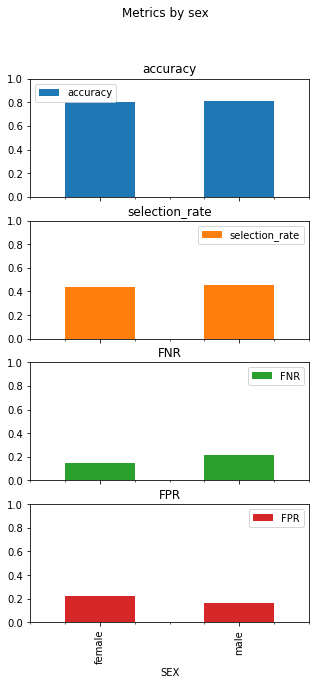

In [47]:
#@title


# Make the post-processed model
postprocessed_model_fnr = ThresholdOptimizer(
    estimator=default_model,
    constraints='false_negative_rate_parity',
    objective='balanced_accuracy_score',
    prefit=True,
    predict_method='predict_proba'
)

# Fit the model to the training data
postprocessed_model_fnr.fit(X_train, y_train, sensitive_features=X_train['SEX'])

# Predict on the test data
y_pred_to_fnr = postprocessed_model_fnr.predict(X_test, sensitive_features=X_test['SEX'])  

# Make a metricframe
grouped_on_sex_to_fnr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_to_fnr,
    sensitive_features=sensitive_feature
)

# Plot a metricframe grouped by sex
grouped_on_sex_to.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

In [46]:
#@title
# print the fairness of the unaltered model
print("Naive Model's results:")
print(f'  Demographic parity difference: {demo_parity_diff:.4f}')
print(f'  Demographic parity ratio: {demo_parity_ratio:.4f}')
print(f'  Male selection rate: {male_selection_rate:.4f}')
print(f'  Female selection rate: {female_selection_rate:.4f}')
print()


# evaluate fairness of the classifier with Correlation Remover
print('ThresholdOptimizer (for FNR) results:')

#compute demographic parity difference and demographic parity ratio
demo_parity_diff_to_fnr = demographic_parity_difference(y_test, y_pred_to_fnr, sensitive_features=X_test_sexes)
demo_parity_ratio_to_fnr = demographic_parity_ratio(y_test, y_pred_to_fnr, sensitive_features=X_test_sexes)

print(f'  Demographic parity difference: {demo_parity_diff_to_fnr:.4f}')
print(f'  Demographic parity ratio: {demo_parity_ratio_to_fnr:.4f}')

#compute selection rate for males and females
male_selection_rate_to_fnr = selection_rate(y_test[X_test_sexes==1], y_pred_to_fnr[X_test_sexes==1])
female_selection_rate_to_fnr = selection_rate(y_test[X_test_sexes==0], y_pred_to_fnr[X_test_sexes==0])

print(f'  Male selection rate: {male_selection_rate_to_fnr:.4f}')
print(f'  Female selection rate: {female_selection_rate_to_fnr:.4f}')

Naive Model's results:
  Demographic parity difference: 0.1483
  Demographic parity ratio: 0.6849
  Male selection rate: 0.4707
  Female selection rate: 0.3224

ThresholdOptimizer (for FNR) results:
  Demographic parity difference: 0.0959
  Demographic parity ratio: 0.8051
  Male selection rate: 0.4918
  Female selection rate: 0.3959


#**TODO 8**: Is the ThresholdOptimizer successful at balancing false negative rates? Is it fair?

**Answer**:   Now that we are targetting false negative rates, the demographic parity difference in terms of FNR is lower than the one we find in the Naive model, but still pretty high, It is almost a 0.10 parity difference. Then, it was not that successful at balancing false negative rates. Therefore, it is still not fair, if we are considering the main fairness metric to be FP and FN rates. 

Aside from that, the same history we mentioned in part 7 reapears: the false positive rate for females is higher than for males, and the false negative rate is higher for males than females. This is sort of what we were trying to avoid on the first place, so it is still not perfectly fair, because now it is not fair for males, if we are using FPR and FNR as our key elements to evaluate fairness.


#**TODO 9**: Which of all the methods we tried in this lab was the most effective?

**Answer:** In terms of Selection rates, the thresholdOptimizer method was the most effective at reducing demographic parity difference (increasing parity ratio). In terms of accuracy and other characteristics, it was fairly close to the pre-processing model of deleting correlation between sensitive variables and the rest of the data, but still thresholdOptimizer performed somewhat better.

Now, if our main metric was FP and FN rates, then the answer remains unclear: by looking at the graphs, it seems that the parity ratio is higher for thresholdOptimizer than it is for uncorrelation methods, but since we did not evaluate for this parity in uncorrelation methods, it remains unclear.